- In this project, we will use a pre-trained neural network called MobileNet
- We will use the TensorFlow Flowers database
- Code based on the documentation below:
https://www.tensorflow.org/beta/tutorials/images/hub_with_keras

# Step 1: Importing the libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile

In [2]:
!pip install tensorflow_hub --upgrade
import tensorflow_hub as hub

#Step 2: Importing the pre-trained model

In [3]:
trained_MobileNet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
trained_MobileNet = tf.keras.Sequential([hub.KerasLayer(trained_MobileNet_url,
                                                        input_shape=(224,224,3))])

# Step 3: Testing with the pre-trained model

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/My Drive/Transfer-Learning-Data.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [7]:
sample_image= tf.keras.preprocessing.image.load_img(r'/content/Transfer Learning Data/watch.jpg',
                                                    target_size = (224, 224))

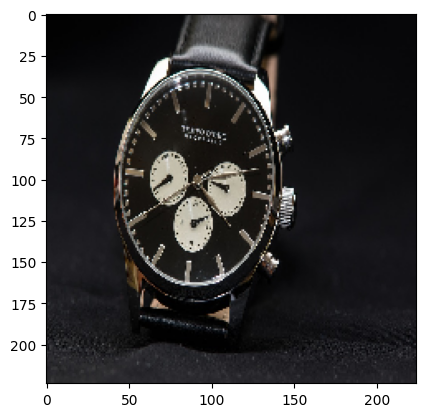

In [8]:
plt.imshow(sample_image)

In [9]:
sample_image = np.array(sample_image) / 255.0

In [10]:
sample_image.shape

(224, 224, 3)

In [11]:
predicted_class = trained_MobileNet.predict(np.expand_dims(sample_image, axis = 0))

1/1 [==============================] - 1s 727ms/step


In [12]:
predicted_class

array([[ 0.31899288,  0.6976617 , -0.48101687, ...,  0.22585547,
        -1.4412357 , -0.0252165 ]], dtype=float32)

In [13]:
len(predicted_class[0])

1001

In [14]:
predicted_class.shape

(1, 1001)

In [15]:
predicted_class = np.argmax(predicted_class)
predicted_class

827

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 1us/step


In [17]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [18]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [19]:
len(imagenet_labels)

1001

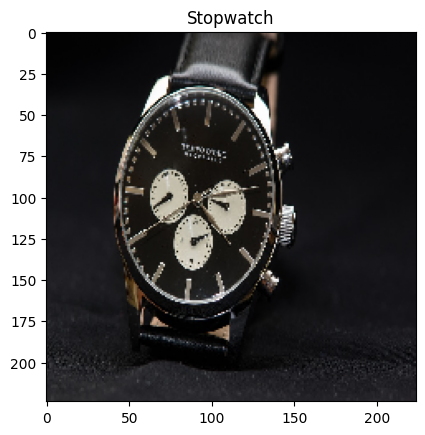

In [20]:
plt.imshow(sample_image)
predicted_class_name = imagenet_labels[predicted_class]
plt.title(predicted_class_name.title());

# Step 4: Testing with a set of images

In [21]:
flowers_data_url = tf.keras.utils.get_file('flower_photos',
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                            untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [22]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
flower_data = image_generator.flow_from_directory(str(flowers_data_url),
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=True)

Found 3670 images belonging to 5 classes.


In [27]:
for flowers_data_input_batch, flowers_data_label_batch in flower_data:
  print("Image batch shape: ", flowers_data_input_batch.shape)
  print("Label batch shape: ", flowers_data_label_batch.shape)
  break

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)


In [32]:
predictions_batch = trained_MobileNet.predict(flowers_data_input_batch)
predictions_batch.shape

2/2 [==============================] - 3s 2s/step


(64, 1001)

In [33]:
predicted_class_names = imagenet_labels[np.argmax(predictions_batch, axis=-1)]
predicted_class_names

array(['daisy', 'daisy', 'daisy', 'hummingbird', 'hip', 'bee', 'crane',
       'barn spider', 'Sealyham terrier', 'pot', 'pirate', 'palace',
       'daisy', 'barn', 'daisy', 'daisy', 'television', 'hip', 'daisy',
       'daisy', 'porcupine', 'picket fence', 'daisy', 'cardoon',
       'sea urchin', 'daisy', 'hip', 'bee', 'feather boa', 'daisy',
       'vase', 'feather boa', 'bonnet', 'picket fence', 'daisy', 'daisy',
       'daisy', 'bee', 'bee', 'daisy', 'daisy', 'teddy', 'picket fence',
       'hair slide', 'coral fungus', 'picket fence',
       "yellow lady's slipper", 'picket fence', 'cauliflower', 'cardoon',
       'rapeseed', 'picket fence', 'daisy', 'daisy', 'daisy', 'vase',
       'hip', 'lab coat', 'rapeseed', 'stinkhorn', 'fly', 'bubble', 'hip',
       'daisy'], dtype='<U30')

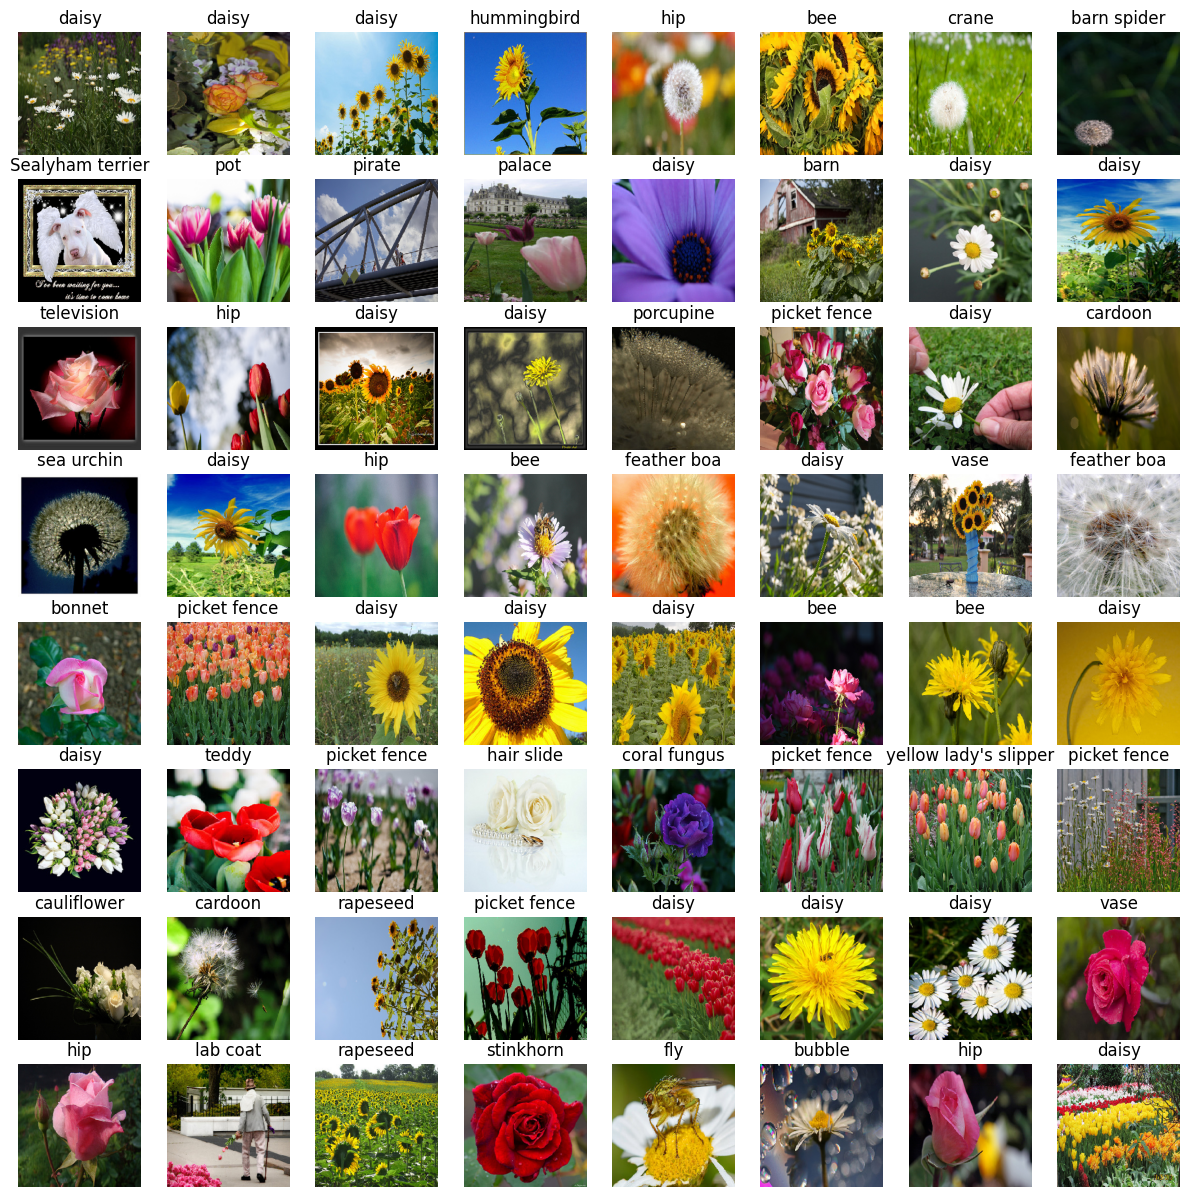

In [38]:
plt.figure(figsize=(15,15))
for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

# Step 5: Transfer learning

In [34]:
MobileNet_feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [35]:
MobileNet_feature_extractor_layer = hub.KerasLayer(MobileNet_feature_extractor_url,
                                                   input_shape=(224, 224, 3))

In [37]:
feature_batch = MobileNet_feature_extractor_layer(flowers_data_input_batch)
feature_batch.shape

TensorShape([64, 1280])

In [39]:
MobileNet_feature_extractor_layer.trainable = False

In [40]:
flower_data.num_classes

5

In [41]:
model = tf.keras.Sequential([MobileNet_feature_extractor_layer,
                             tf.keras.layers.Dense(flower_data.num_classes, activation='softmax')])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [44]:
predictions = model(flowers_data_input_batch)
predictions.shape

TensorShape([64, 5])

In [45]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit_generator(flower_data, epochs=50)

<ipython-input-46-72326cffe83c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(flower_data, epochs=50)


Epoch 1/50
58/58 [==============================] - 202s 3s/step - loss: 0.8040 - accuracy: 0.7076
Epoch 2/50
58/58 [==============================] - 175s 3s/step - loss: 0.3913 - accuracy: 0.8733
Epoch 3/50
58/58 [==============================] - 175s 3s/step - loss: 0.3108 - accuracy: 0.8986
Epoch 4/50
58/58 [==============================] - 172s 3s/step - loss: 0.2625 - accuracy: 0.9183
Epoch 5/50
58/58 [==============================] - 175s 3s/step - loss: 0.2315 - accuracy: 0.9313
Epoch 6/50
58/58 [==============================] - 177s 3s/step - loss: 0.2096 - accuracy: 0.9406
Epoch 7/50
58/58 [==============================] - 177s 3s/step - loss: 0.1911 - accuracy: 0.9477
Epoch 8/50
58/58 [==============================] - 171s 3s/step - loss: 0.1720 - accuracy: 0.9542
Epoch 9/50
58/58 [==============================] - 174s 3s/step - loss: 0.1579 - accuracy: 0.9591
Epoch 10/50
58/58 [==============================] - 172s 3s/step - loss: 0.1453 - accuracy: 0.9635
Epoch 11/

#Step 6: Model Evaluation

In [47]:
class_names = sorted(flower_data.class_indices.items(), key = lambda pair:pair[1])

In [48]:
class_names

[('daisy', 0),
 ('dandelion', 1),
 ('roses', 2),
 ('sunflowers', 3),
 ('tulips', 4)]

In [49]:
class_names = np.array([key.title() for key, value in class_names])

In [50]:
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [51]:
predicted_batch = model.predict(flowers_data_input_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

2/2 [==============================] - 3s 1s/step


In [52]:
predicted_id

array([0, 2, 3, 3, 1, 3, 1, 1, 2, 4, 4, 4, 0, 3, 0, 3, 2, 4, 3, 1, 1, 2,
       0, 1, 1, 3, 4, 0, 1, 0, 3, 1, 2, 4, 3, 3, 3, 2, 1, 1, 4, 4, 4, 2,
       2, 4, 4, 0, 2, 1, 3, 4, 4, 1, 0, 2, 2, 4, 3, 2, 0, 0, 2, 4])

In [53]:
predicted_label_batch

array(['Daisy', 'Roses', 'Sunflowers', 'Sunflowers', 'Dandelion',
       'Sunflowers', 'Dandelion', 'Dandelion', 'Roses', 'Tulips',
       'Tulips', 'Tulips', 'Daisy', 'Sunflowers', 'Daisy', 'Sunflowers',
       'Roses', 'Tulips', 'Sunflowers', 'Dandelion', 'Dandelion', 'Roses',
       'Daisy', 'Dandelion', 'Dandelion', 'Sunflowers', 'Tulips', 'Daisy',
       'Dandelion', 'Daisy', 'Sunflowers', 'Dandelion', 'Roses', 'Tulips',
       'Sunflowers', 'Sunflowers', 'Sunflowers', 'Roses', 'Dandelion',
       'Dandelion', 'Tulips', 'Tulips', 'Tulips', 'Roses', 'Roses',
       'Tulips', 'Tulips', 'Daisy', 'Roses', 'Dandelion', 'Sunflowers',
       'Tulips', 'Tulips', 'Dandelion', 'Daisy', 'Roses', 'Roses',
       'Tulips', 'Sunflowers', 'Roses', 'Daisy', 'Daisy', 'Roses',
       'Tulips'], dtype='<U10')

In [54]:
label_id = np.argmax(flowers_data_label_batch, axis=-1)
label_id

array([0, 2, 3, 3, 1, 3, 1, 1, 2, 4, 4, 4, 0, 3, 0, 3, 2, 4, 3, 1, 1, 2,
       0, 1, 1, 3, 4, 0, 1, 0, 3, 1, 2, 4, 3, 3, 3, 2, 1, 1, 4, 4, 4, 2,
       2, 4, 4, 0, 2, 1, 3, 4, 4, 1, 0, 2, 2, 4, 3, 2, 0, 0, 2, 4])

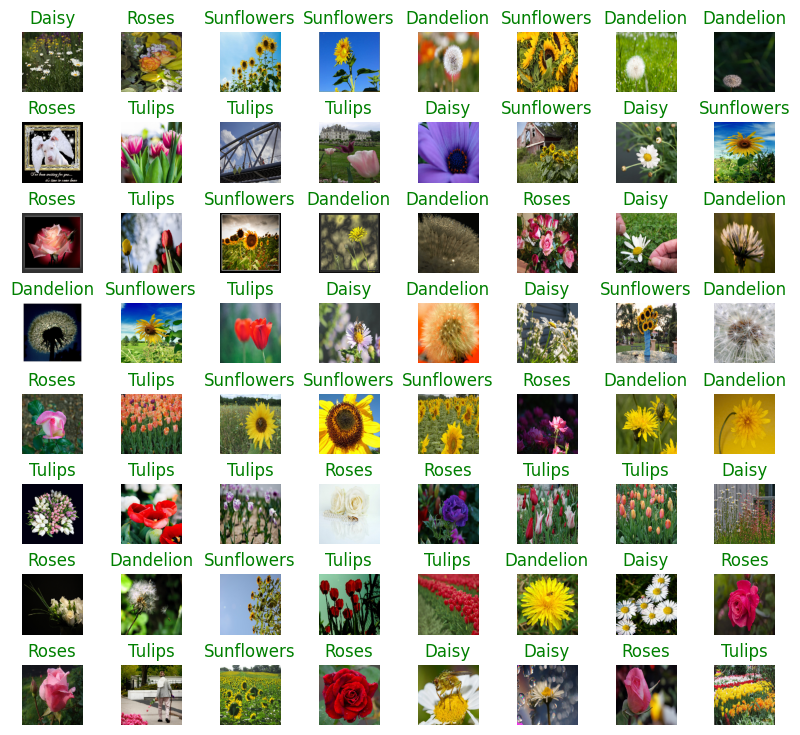

In [55]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(64):
  plt.subplot(8,8,n+1)
  plt.imshow(flowers_data_input_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')